In [1]:
import sys
import glob
import os
import math
import pandas as pd
import numpy as np
import geopandas as gp

import matplotlib.pyplot as plt
import rsfuncs as rs

from scipy import stats
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

In [2]:
# Read data
states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]

# formate data 
df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)

In [3]:
# Filter the data

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

# Calculate spectral indices
# df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
# df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
# df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)

df['ndvi'] = (df.B5_filt - df.B4_filt) / (df.B5_filt + df.B4_filt)
df["ndmi"] = (df.B5_filt - df.B6_filt) / (df.B5_filt + df.B6_filt)
df["evi"] = 2.5*(df.B5_filt - df.B4_filt) / (df.B5_filt + 6*df.B4_filt - 7.5*df.B2_filt + 1)

# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean 
vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))


df['vv'] = vv_eff
df['hv'] = hv_eff

# calc the 12 day means for each site: 
df = df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna()


In [4]:
# Drop the non interpolated landsat bands
df.drop(["B1", "B2", "B3", "B4", "B5", "B6", "B7"], axis = 1,inplace = True)
df.rename(columns={'B1_filt': 'B1', 'B2_filt': 'B2','B3_filt': 'B3','B4_filt': 'B4','B5_filt': 'B5','B6_filt': 'B6','B7_filt': 'B7'}, inplace=True)

# cols = [c for c in df.columns if 'filt' not in c]
# df=df[cols]

In [5]:
# One hot encode the landcover types *** figure this out
# df = df.lc_type.astype(str)
one_hot = pd.get_dummies(df.lc_type, drop_first=True )
rdf = pd.concat([df, one_hot], axis = 1)
rdf = rdf.drop(["lc_type"], axis = 1)
# df = rdf.reset_index(level='site')
df = rdf.dropna()
df.columns = df.columns.map(str)

In [6]:
# Add the time lagged predictors 
s1 = df.groupby(level="site").shift(1)
df1 = df.join(s1.rename(columns=lambda x: x+"_t1"))

s2 = df.groupby(level="site").shift(2)
df2 = df1.join(s2.rename(columns=lambda x: x+"_t2"))

df3 = df2.copy()
# s3 = df.groupby(level="site").shift(3)
# df3 = df2.join(s3.rename(columns=lambda x: x+"_t3"))

In [7]:
# Drop unnecessary cols 

In [8]:
dropstrs = ['site','precip', 'rzsm_', 'ssm', 'psi_rz', "psi_s"]
dropcols = []

for i in df3.columns:
    for x in dropstrs:
        if x in i:
            dropcols.append(i)
            
df3 = df3.drop(dropcols, axis = 1)

In [9]:
# Reset the index and drop nans 
df = df3.reset_index(level='site')
df = df.dropna()

In [10]:
# Modeling options

EPOCHS = 100
BATCHSIZE = 50
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l1(0.00005)
Breg = regularizers.l2(0.001)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

def build_model(input_shape):
    # make the model 
    model = Sequential()
    
    model.add(LSTM(50, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(25, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(5, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,bias_regularizer= Breg))

    model.add(Dense(1))
    model.compile(loss=LOSS, optimizer= "Nadam",
                  metrics=['mse'])
    
    return model


In [11]:
out = {"train_preds":[], # rs
       "test_preds":[], # wells
       "train_act":[], # c2vsim
       "test_act":[]  # grace 
        }

In [20]:
import random

Processing 2116
Train on 2974 samples, validate on 15 samples
Epoch 1/500
 - 3s - loss: 1.0728 - mse: 0.9929 - val_loss: 11.2753 - val_mse: 11.1959
Epoch 2/500
 - 0s - loss: 1.0486 - mse: 0.9692 - val_loss: 11.4472 - val_mse: 11.3682
Epoch 3/500
 - 0s - loss: 1.0250 - mse: 0.9461 - val_loss: 11.5981 - val_mse: 11.5196
Epoch 4/500
 - 0s - loss: 1.0000 - mse: 0.9215 - val_loss: 11.8140 - val_mse: 11.7359
Epoch 5/500
 - 0s - loss: 0.9719 - mse: 0.8938 - val_loss: 12.1151 - val_mse: 12.0375
Epoch 6/500
 - 0s - loss: 0.9384 - mse: 0.8608 - val_loss: 12.5034 - val_mse: 12.4262
Epoch 7/500
 - 0s - loss: 0.9041 - mse: 0.8269 - val_loss: 12.8886 - val_mse: 12.8118
Epoch 8/500
 - 0s - loss: 0.8655 - mse: 0.7888 - val_loss: 13.4192 - val_mse: 13.3428
Epoch 9/500
 - 0s - loss: 0.8338 - mse: 0.7576 - val_loss: 13.9429 - val_mse: 13.8670
Epoch 10/500
 - 0s - loss: 0.8060 - mse: 0.7303 - val_loss: 14.3701 - val_mse: 14.2947
Epoch 11/500
 - 0s - loss: 0.7775 - mse: 0.7023 - val_loss: 14.7440 - val_mse

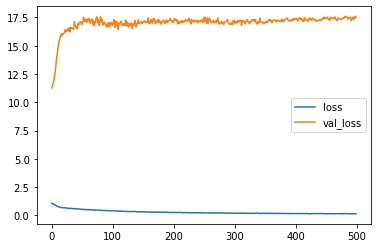

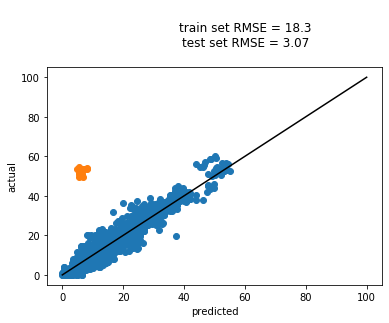

Processing 2133
Train on 2948 samples, validate on 41 samples
Epoch 1/500
 - 3s - loss: 1.0710 - mse: 0.9911 - val_loss: 0.1654 - val_mse: 0.0860
Epoch 2/500
 - 0s - loss: 1.0480 - mse: 0.9687 - val_loss: 0.1585 - val_mse: 0.0795
Epoch 3/500
 - 0s - loss: 1.0277 - mse: 0.9488 - val_loss: 0.1578 - val_mse: 0.0793
Epoch 4/500
 - 0s - loss: 1.0050 - mse: 0.9265 - val_loss: 0.1661 - val_mse: 0.0881
Epoch 5/500
 - 0s - loss: 0.9764 - mse: 0.8984 - val_loss: 0.1980 - val_mse: 0.1204
Epoch 6/500
 - 0s - loss: 0.9446 - mse: 0.8671 - val_loss: 0.2564 - val_mse: 0.1792
Epoch 7/500
 - 0s - loss: 0.9140 - mse: 0.8369 - val_loss: 0.3486 - val_mse: 0.2719
Epoch 8/500
 - 0s - loss: 0.8779 - mse: 0.8013 - val_loss: 0.4888 - val_mse: 0.4126
Epoch 9/500
 - 0s - loss: 0.8496 - mse: 0.7735 - val_loss: 0.6856 - val_mse: 0.6099
Epoch 10/500
 - 0s - loss: 0.8231 - mse: 0.7475 - val_loss: 0.9123 - val_mse: 0.8371
Epoch 11/500
 - 0s - loss: 0.8064 - mse: 0.7313 - val_loss: 1.1391 - val_mse: 1.0644
Epoch 12/500

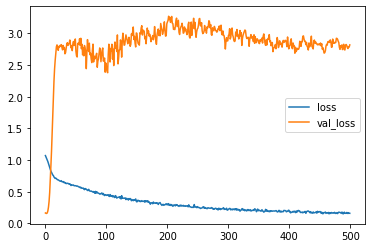

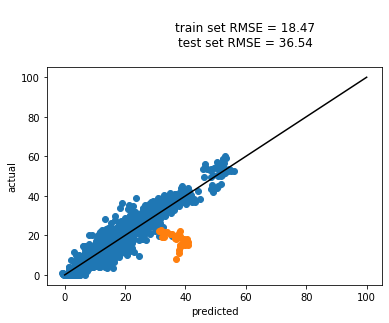

Processing 2118
Train on 2941 samples, validate on 48 samples
Epoch 1/500
 - 3s - loss: 1.0914 - mse: 1.0115 - val_loss: 0.6801 - val_mse: 0.6007
Epoch 2/500
 - 0s - loss: 1.0707 - mse: 0.9914 - val_loss: 0.6969 - val_mse: 0.6179
Epoch 3/500
 - 0s - loss: 1.0531 - mse: 0.9742 - val_loss: 0.7356 - val_mse: 0.6571
Epoch 4/500
 - 0s - loss: 1.0328 - mse: 0.9544 - val_loss: 0.7637 - val_mse: 0.6857
Epoch 5/500
 - 0s - loss: 1.0099 - mse: 0.9319 - val_loss: 0.8055 - val_mse: 0.7279
Epoch 6/500
 - 0s - loss: 0.9827 - mse: 0.9052 - val_loss: 0.8503 - val_mse: 0.7732
Epoch 7/500
 - 0s - loss: 0.9510 - mse: 0.8740 - val_loss: 0.8823 - val_mse: 0.8057
Epoch 8/500
 - 0s - loss: 0.9191 - mse: 0.8426 - val_loss: 0.9419 - val_mse: 0.8657
Epoch 9/500
 - 0s - loss: 0.8839 - mse: 0.8078 - val_loss: 1.0164 - val_mse: 0.9407
Epoch 10/500
 - 0s - loss: 0.8518 - mse: 0.7762 - val_loss: 1.0772 - val_mse: 1.0020
Epoch 11/500
 - 0s - loss: 0.8288 - mse: 0.7536 - val_loss: 1.1245 - val_mse: 1.0498
Epoch 12/500

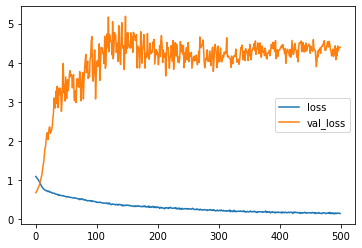

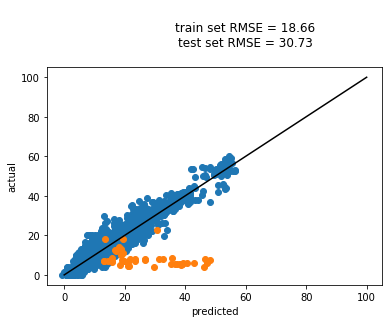

Processing 2142
Train on 2948 samples, validate on 41 samples
Epoch 1/500
 - 3s - loss: 1.0846 - mse: 1.0047 - val_loss: 0.5488 - val_mse: 0.4694
Epoch 2/500
 - 0s - loss: 1.0622 - mse: 0.9829 - val_loss: 0.5309 - val_mse: 0.4519
Epoch 3/500
 - 0s - loss: 1.0412 - mse: 0.9623 - val_loss: 0.4954 - val_mse: 0.4169
Epoch 4/500
 - 0s - loss: 1.0196 - mse: 0.9412 - val_loss: 0.4674 - val_mse: 0.3893
Epoch 5/500
 - 0s - loss: 0.9956 - mse: 0.9176 - val_loss: 0.4185 - val_mse: 0.3409
Epoch 6/500
 - 0s - loss: 0.9658 - mse: 0.8883 - val_loss: 0.3676 - val_mse: 0.2904
Epoch 7/500
 - 0s - loss: 0.9340 - mse: 0.8569 - val_loss: 0.3281 - val_mse: 0.2514
Epoch 8/500
 - 0s - loss: 0.9054 - mse: 0.8288 - val_loss: 0.2946 - val_mse: 0.2184
Epoch 9/500
 - 0s - loss: 0.8748 - mse: 0.7987 - val_loss: 0.2311 - val_mse: 0.1554
Epoch 10/500
 - 0s - loss: 0.8504 - mse: 0.7748 - val_loss: 0.1883 - val_mse: 0.1131
Epoch 11/500
 - 0s - loss: 0.8239 - mse: 0.7488 - val_loss: 0.1748 - val_mse: 0.1001
Epoch 12/500

KeyboardInterrupt: 

In [51]:
for i in random.sample(set(df.site.unique()), len(df.site.unique())):

    print("Processing {}".format(i))
    
    # Hold one out cross validation - loop through sites and select 1 to test on and the rest to train 
    sdf = df[df.site == i]
    y_test = sdf.rzsm
    X_test = sdf.drop(["site","rzsm"], axis=1)

    nsdf = df[df.site != i]
    y_train = nsdf.rzsm 
    X_train = nsdf.drop(["site","rzsm"], axis=1)
        
    # Scale data
    transformer_x = StandardScaler().fit(X_train)
    transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
#     transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
#     transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # LSTM params
    n_lags = 3
    n_features = 19

    X_train = X_train.reshape((X_train.shape[0], n_lags, 19))
    X_test = X_test.reshape((X_test.shape[0], n_lags, 19))

    input_shape=(X_train.shape[1], X_train.shape[2])
    
    model = build_model(input_shape=input_shape)
    
    # Fit
#     model.fit(X_train, y_train, epochs=1000, batch_size=1000, verbose=1)
    
    train_history = model.fit(X_train, y_train,epochs = 500,
                    batch_size=2000,
                    verbose=2, validation_data=(X_test, y_test))
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    val_acc = train_history.history['val_mse']

    # Get the predictions
    yhat_train = model.predict(X_train)
    
    trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
    trainY = transformer_y.inverse_transform(y_train)
    
    yhat = model.predict(X_test)
    testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
    testY = transformer_y.inverse_transform(y_test)

    trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    
    out["test_preds"] = testPredict
    out["train_preds"] = trainPredict
    
    out["test_act"] = testY
    out["train_act"] = trainY
    
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.show()

    plt.scatter(trainPredict, trainY)
    plt.scatter(testPredict, testY)
    plt.plot([0, 100], [0, 100], 'k-')
    plt.title('''
                train set RMSE = {}
                test set RMSE = {}
                '''.format(round(trainScore,2),round(testScore,2)))

    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

In [76]:

#added some parameters
kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
result = next(kf.split(df), None)

In [81]:
len(df.iloc[result[0]])

2391

In [82]:
len(df.iloc[result[1]])

598

In [74]:
t = kf.split(df.groupby("site"))

In [75]:
t

<generator object _BaseKFold.split at 0x1c59479620>

In [ ]:
for i in df.site.unique():
    sdf = df[df.site == i]
    max_len = 0
    if len(sdf)>max_len:
        max_len = len(sdf)
        answer = i
    else:
        continue

In [ ]:
answer